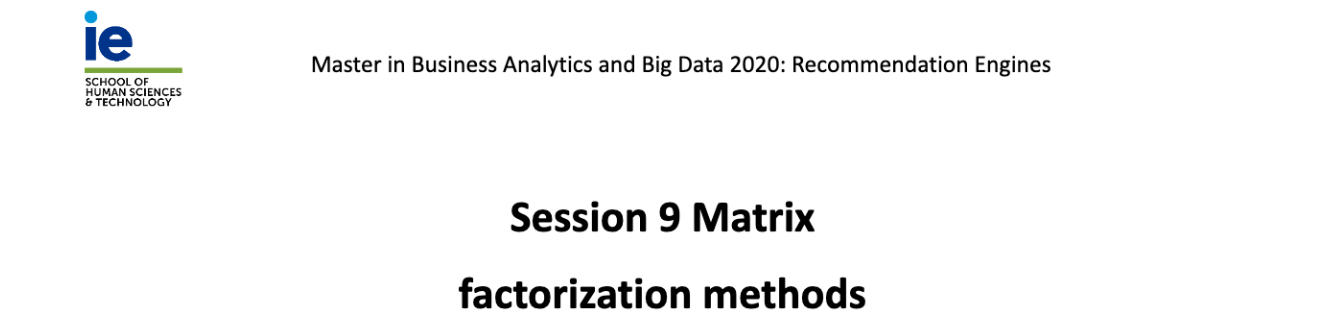

# Introduction

Please make sure that you are connected to a hosted Google Colab environment. If that's the case, at the upper right part of your screen you should see a green check mark like this one 

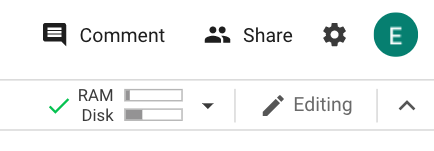

If you are not connected, please click on Connect button 

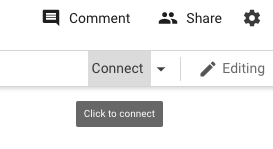

**Before continue, please expand all notebook sections, View->Expand sections**

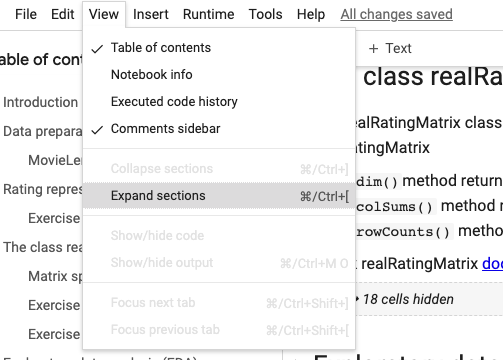



After that please, execute cells below to install required libraries, it will take a couple of minutes. 

## Environment setup

In [1]:
install.packages(c('dplyr','ggplot2','knitr','recommenderlab'))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppProgress’, ‘arules’, ‘proxy’, ‘registry’, ‘irlba’, ‘recosystem’




In [2]:
library(dplyr)
library(ggplot2)
library(knitr)
library(recommenderlab)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix

Loading required package: arules


Attaching package: ‘arules’


The following object is masked from ‘package:dplyr’:

    recode


The following objects are masked from ‘package:base’:

    abbreviate, write


Loading required package: proxy


Attaching package: ‘proxy’


The following object is masked from ‘package:Matrix’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


Loading required package: registry

Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy




# Introduction to latent factors. 

**Latent factor recommenders are a relatively new discovery**, getting their real breakthrough when the **Netflix Prize competition** promised $1 million to anyone who could improve Netflix’s recommendations by at least 10%. The winner was an ensemble recommender algorithm, which means mixing many different algorithms to produce the final result . The winning **ensemble was so complicated that it never went into production.** 

Instead, another solution made by Simon Funk became famous for getting close to winning because he [blogged about it](https://www.kdd.org/exploration_files/simon-funk-explorations.pdf). In this lab we'll learn the basic method known as SVD and some matrix decomposition techniques, like Funk SVD (name after Simon Funk) and ALS, all of them already implemented in the recommenderLab package.


# What is a latent factor

A latent factor is not observed in our data, rather, we infer it based on the value (ratings) given by the user to the item. For example an user gives a score of 9/10 to two action movies and a score of 2/10 to two drama movies. There is a relation between the score and the content of the movies (action and drama). But action and drame aren’t present in our rating data, these features are called Latent features.

The idea of matrix factorization methods is to approximatte our rating matrix discovering these latent factor both for users and items. 

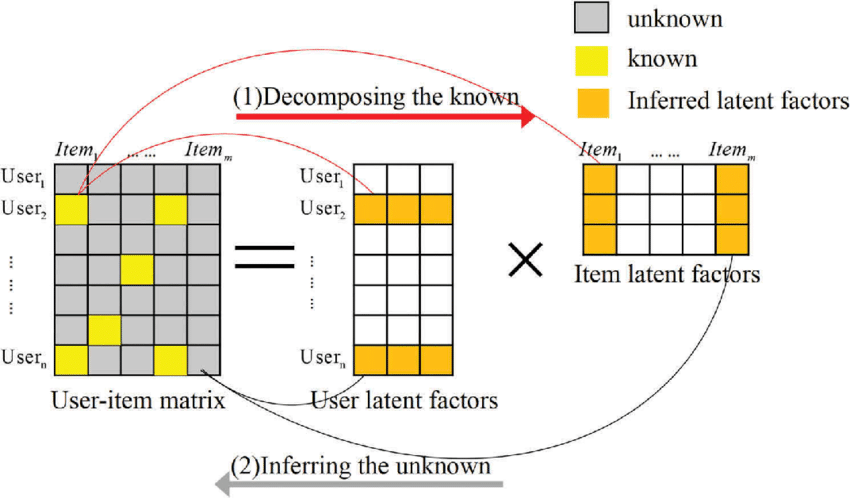

# SVD 

One of the most commonly used methods for matrix factorization is an algorithm called SVD (singular value decomposition). You want to find items to recommend to users, and you want to do it using extracted factors from the rating matrix. The idea of factorization is even more complicated because you want to end up with a formula that enables you to add new users and items easily. 

From the rating matrix $M$, you want to construct two matrices that you can use: one that represents the customer’s taste and one that contains the item profiles. Using SVD, you construct three matrices: $U$, $\sum$, and $V^T$ (also known as $V^*$ depending on which book you look in). Because you want to end up with two matrices, you multiply the square root of $\sum$ on one of the two others, and then you only have two left. But before doing that, you want to use the middle matrix that gives you information about how much you should reduce the dimensions.

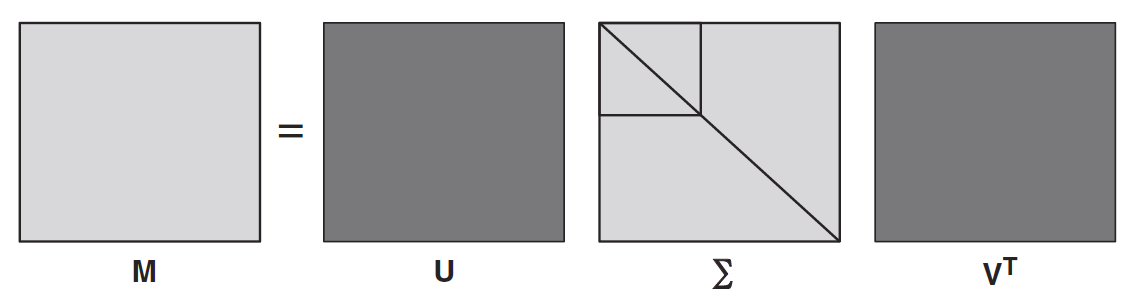

- $M$ Is our rating matrix that we want to decompose
- $U$ User feature matrix 
- $\sum$ Weights diagonal
- $V^T$ Item feature matrix



SVD is only defined for complete matrices. Therefore we need to fill in these missing values before (SVD is not a imputing-algorithm per se). The errors you introduce will hopefully be cancelled out by your matrix-factorization approach (general assumption: data is generated by a low-rank model).


In [26]:
recommenderRegistry$get_entry("SVD", dataType="realRatingMatrix")

Recommender method: SVD for realRatingMatrix
Description: Recommender based on SVD approximation with column-mean imputation.
Reference: NA
Parameters:
   k maxiter normalize
1 10     100  "center"

There three parameters to take into account for SVD
- k: Which is the number of latent factors for matrices $U$ and $V^T$
- normalize: Which specifies the kind of normalization performed to rating matrix. 
- maxiter: Specifies the maximum number of iteration during the SVD aproximation.  

In [27]:
data(MovieLense)
ratings_movies <- MovieLense[rowCounts(MovieLense) > 20,
colCounts(MovieLense) > 30]
ratings_movies

898 x 792 rating matrix of class ‘realRatingMatrix’ with 90115 ratings.

In [28]:
items_to_keep <- 15

Evaluating a model consists of comparing the recommendations with the unknown ratings. The ratings are between 1 and 5, and we need to define what constitutes good and bad items. For this purpose, we will define a threshold with the minimum
rating that is considered good:

In [29]:
rating_threshold <- 3

In [30]:
n_fold <- 4
eval_sets <- evaluationScheme(data = ratings_movies, method = "cross-validation",
k = n_fold, given = items_to_keep, goodRating = rating_threshold)
size_sets <- sapply(eval_sets@runsTrain, length)
size_sets

[1] 672 672 672 672

In [31]:
method <- "SVD"
params <- list(verbose =TRUE)
svd <- Recommender(data = getData(eval_sets, "train"), method = method, parameter = params)

Used parameters:
k	 =  10
maxiter	 =  100
normalize	 =  center
verbose	 =  TRUE


In [32]:
models_to_evaluate <- list(
svd = list(name = "SVD" )
)

In [33]:
results_svd <- evaluate(x = eval_sets, method = models_to_evaluate, n =seq(10, 100, 10), type="ratings")
class(results_svd)

SVD run fold/sample [model time/prediction time]
	 1  [0.06sec/0.051sec] 
	 2  [0.064sec/0.052sec] 
	 3  [0.062sec/0.06sec] 
	 4  [0.068sec/0.272sec] 


[1] "evaluationResultList"
attr(,"package")
[1] "recommenderlab"

In [34]:
avg(results_svd)

RMSE,MSE,MAE
1.048495,1.099765,0.8374079


In [35]:
results_SVD <- evaluate(x = eval_sets, method = models_to_evaluate, n =seq(10, 100, 10))
class(results_svd)

SVD run fold/sample [model time/prediction time]
	 1  [0.063sec/0.104sec] 
	 2  [0.056sec/0.11sec] 
	 3  [0.057sec/0.106sec] 
	 4  [0.065sec/0.103sec] 


[1] "evaluationResultList"
attr(,"package")
[1] "recommenderlab"

In [36]:
avg(results_SVD)

TP,FP,FN,TN,N,precision,recall,TPR,FPR,n
3.373894,6.626106,68.59071,698.4093,777,0.3373894,0.06474107,0.06474107,0.00914244,10
5.865044,14.134956,66.09956,690.9004,777,0.2932522,0.10074073,0.10074073,0.01956589,20
7.990044,22.009956,63.97456,683.0254,777,0.2663348,0.13229730,0.13229730,0.03055578,30
9.915929,30.084071,62.04867,674.9513,777,0.2478982,0.15991252,0.15991252,0.04183726,40
11.692478,38.307522,60.27212,666.7279,777,0.2338496,0.18551946,0.18551946,0.05336484,50
13.308628,46.691372,58.65597,658.3440,777,0.2218105,0.20875361,0.20875361,0.06514245,60
14.817478,55.182522,57.14712,649.8529,777,0.2116783,0.22993777,0.22993777,0.07709542,70
16.219027,63.780973,55.74558,641.2544,777,0.2027378,0.24899399,0.24899399,0.08919755,80
17.518805,72.481195,54.44580,632.5542,777,0.1946534,0.26728510,0.26728510,0.10146824,90
18.762168,81.237832,53.20243,623.7976,777,0.1876217,0.28362826,0.28362826,0.11382682,100


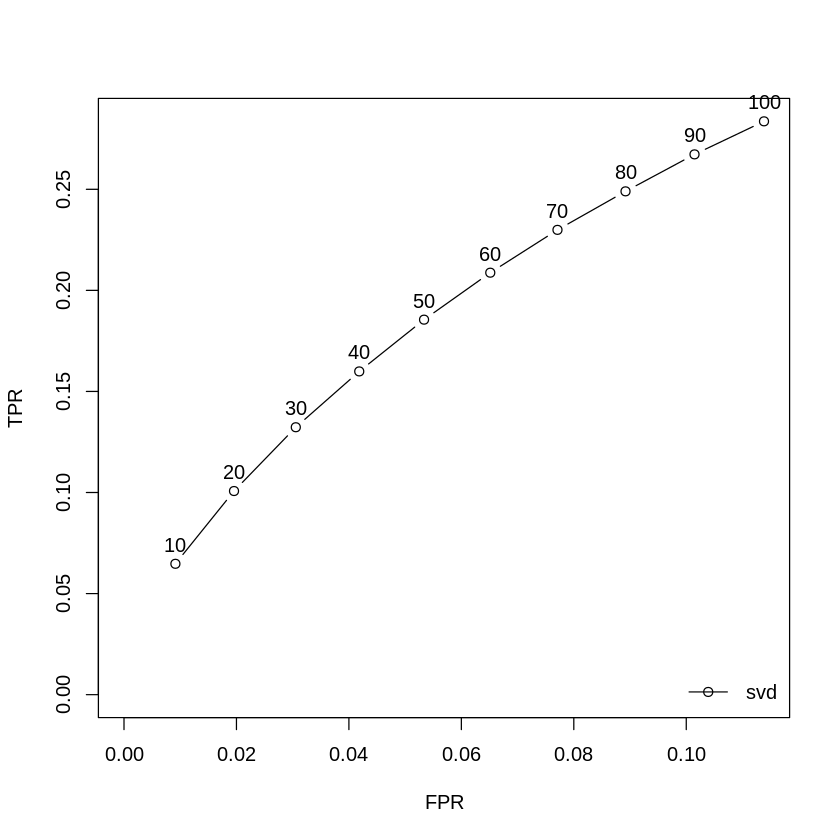

In [40]:
plot(results_SVD, annotate = TRUE, main = "ROC curve")

## Exercise 1 (3 points) 

Please following the example of exercise 9 from session 7, find the value k that obtains better results in ROC curve, search values from 5 to 100 using a step equal to 5.  

```
vector_k <- c(5, 10, 20, 30, 40)
models_to_evaluate <- lapply(vector_k, function(k){
list(name = "IBCF", param = list(method = "cosine", k = k))
})
names(models_to_evaluate) <- paste0("IBCF_k_", vector_k)

```
- **Hint: Change the name method name="IBCF" and remove those parameters that are no needed like cosine distance**



SVD run fold/sample [model time/prediction time]
	 1  [0.059sec/0.343sec] 
	 2  [0.057sec/0.104sec] 
	 3  [0.052sec/0.114sec] 
	 4  [0.043sec/0.104sec] 
SVD run fold/sample [model time/prediction time]
	 1  [0.053sec/0.337sec] 
	 2  [0.068sec/0.104sec] 
	 3  [0.057sec/0.11sec] 
	 4  [0.063sec/0.128sec] 
SVD run fold/sample [model time/prediction time]
	 1  [0.081sec/0.319sec] 
	 2  [0.075sec/0.106sec] 
	 3  [0.086sec/0.116sec] 
	 4  [0.083sec/0.104sec] 
SVD run fold/sample [model time/prediction time]
	 1  [0.109sec/0.105sec] 
	 2  [0.111sec/0.327sec] 
	 3  [0.105sec/0.106sec] 
	 4  [0.103sec/0.115sec] 
SVD run fold/sample [model time/prediction time]
	 1  [0.131sec/0.104sec] 
	 2  [0.129sec/0.122sec] 
	 3  [0.123sec/0.113sec] 
	 4  [0.129sec/0.114sec] 


[1] "evaluationResultList"
attr(,"package")
[1] "recommenderlab"

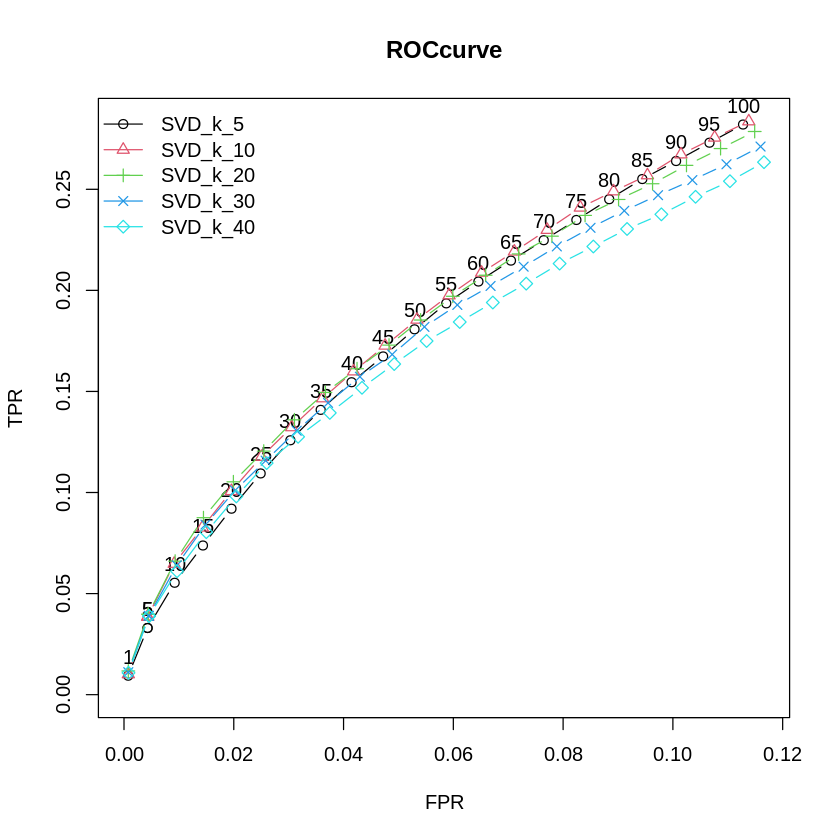

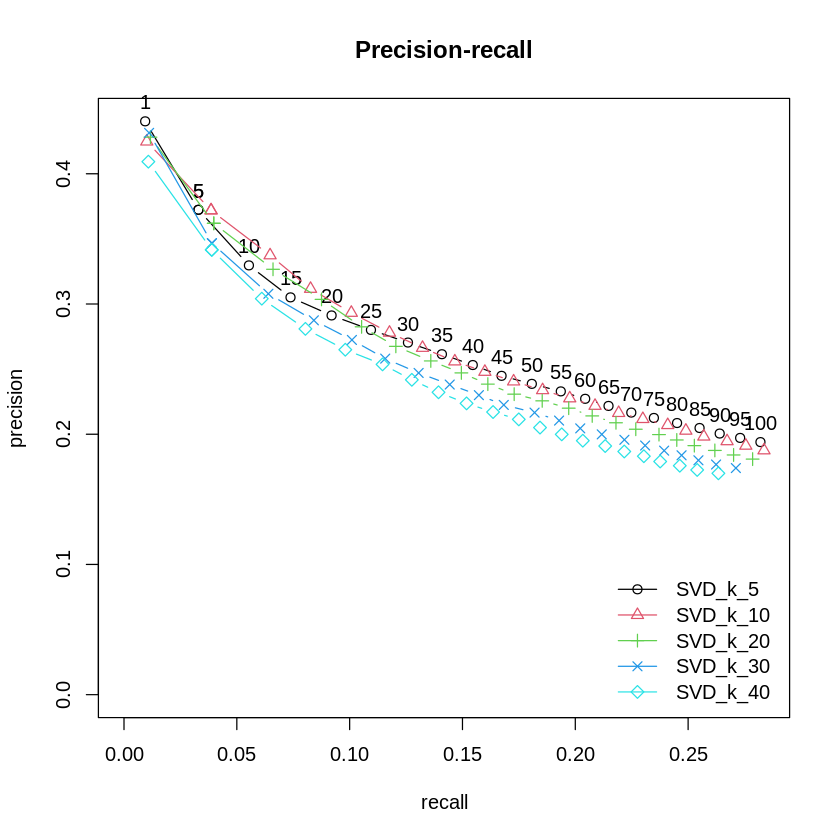

In [41]:
## INSERT YOUR CODE HERE
vector_k <- c(5, 10, 20, 30, 40)
models_to_evaluate <- lapply(vector_k, function(k){
list(name = "SVD", param = list(k = k))
})
names(models_to_evaluate) <- paste0("SVD_k_", vector_k)

n_recommendations <- c(1, 5, seq(5, 100, 5))
list_results <- evaluate(x = eval_sets, method = models_to_evaluate, n= n_recommendations)
class(list_results)## evaluationResultList

plot(list_results, annotate = 1, legend = "topleft") 
title("ROCcurve")
plot(list_results, "prec/rec", annotate = 1, legend = "bottomright")
title("Precision-recall")

# FUNK SVD or regularized SVD

As we saw in the introduction this method is named after Simon Funk became famous for getting close to winning because he [blogged about it](https://www.kdd.org/exploration_files/simon-funk-explorations.pdf).

The SVD method puts much weight into the rating matrix, but that’s a sparse matrix and shouldn’t be relied on too heavily in the sense that finding a cell that’s populated with a rating can be below 1%. Instead of using the whole matrix, Simon Funk came up with a method that only uses the things you need to know. The Funk SVD is also often referred to as regularized SVD.

The idea behind Funk SVD is to minimize a loss function, computing the errors between known ratings and approximated ones given matrices $U \cdot V^T$ .  This function predict in this implementation folds in new data rows by estimating the u vectors
**using stochastic gradient descend**





In [42]:
recommenderRegistry$get_entry_names()

[1] "HYBRID_realRatingMatrix"         "HYBRID_binaryRatingMatrix"      
 [3] "ALS_realRatingMatrix"            "ALS_implicit_realRatingMatrix"  
 [5] "ALS_implicit_binaryRatingMatrix" "AR_binaryRatingMatrix"          
 [7] "IBCF_binaryRatingMatrix"         "IBCF_realRatingMatrix"          
 [9] "LIBMF_realRatingMatrix"          "POPULAR_binaryRatingMatrix"     
[11] "POPULAR_realRatingMatrix"        "RANDOM_realRatingMatrix"        
[13] "RANDOM_binaryRatingMatrix"       "RERECOMMEND_realRatingMatrix"   
[15] "RERECOMMEND_binaryRatingMatrix"  "SVD_realRatingMatrix"           
[17] "SVDF_realRatingMatrix"           "UBCF_binaryRatingMatrix"        
[19] "UBCF_realRatingMatrix"

In [43]:
recommenderRegistry$get_entry("SVDF", dataType="realRatingMatrix")

Recommender method: SVDF for realRatingMatrix
Description: Recommender based on Funk SVD with gradient descend (https://sifter.org/~simon/journal/20061211.html).
Reference: NA
Parameters:
   k gamma lambda min_epochs max_epochs min_improvement normalize verbose
1 10 0.015  0.001         50        200           1e-06  "center"   FALSE

There are six parameters to take into account for SVDF
- **k:** Which is the number of latent factors for matrices $U$ and $V^T$
- **gamma:** regularization term which penalizes those values from $U$ and $V^T$ that are not equal to zero. 
- **lambda:** learning rate.
- **min_improvement:** required minimum improvement per iteration.
- **min_epochs:** minimum number of iterations per feature.
- **max_epochs:** maximum number of iterations per feature.

In [44]:
models_to_evaluate <- list(
svd_funk = list(name = "SVDF" ))

In [45]:
results <- evaluate(x = eval_sets, method = models_to_evaluate, n =seq(10, 100, 10), type="ratings")
class(results)

SVDF run fold/sample [model time/prediction time]
	 1  [45.808sec/9.749sec] 
	 2  [38.543sec/8.346sec] 
	 3  [50.546sec/10.845sec] 
	 4  [46.758sec/9.737sec] 


[1] "evaluationResultList"
attr(,"package")
[1] "recommenderlab"

In [46]:
avg(results)

RMSE,MSE,MAE
0.9686164,0.9386449,0.7605062


## Exercise 2 (2 points)

Change the type evaluation and plot the ROC and the precision-recall curve for SVDF using the default parameters both for the alfgorithm and for the evaluation method.



```
results <- evaluate(x = eval_sets, method = models_to_evaluate, n =seq(10, 100, 10))
```



SVDF run fold/sample [model time/prediction time]
	 1  [47.747sec/9.825sec] 
	 2  [39.156sec/8.696sec] 
	 3  [50.655sec/10.766sec] 
	 4  [46.464sec/9.847sec] 


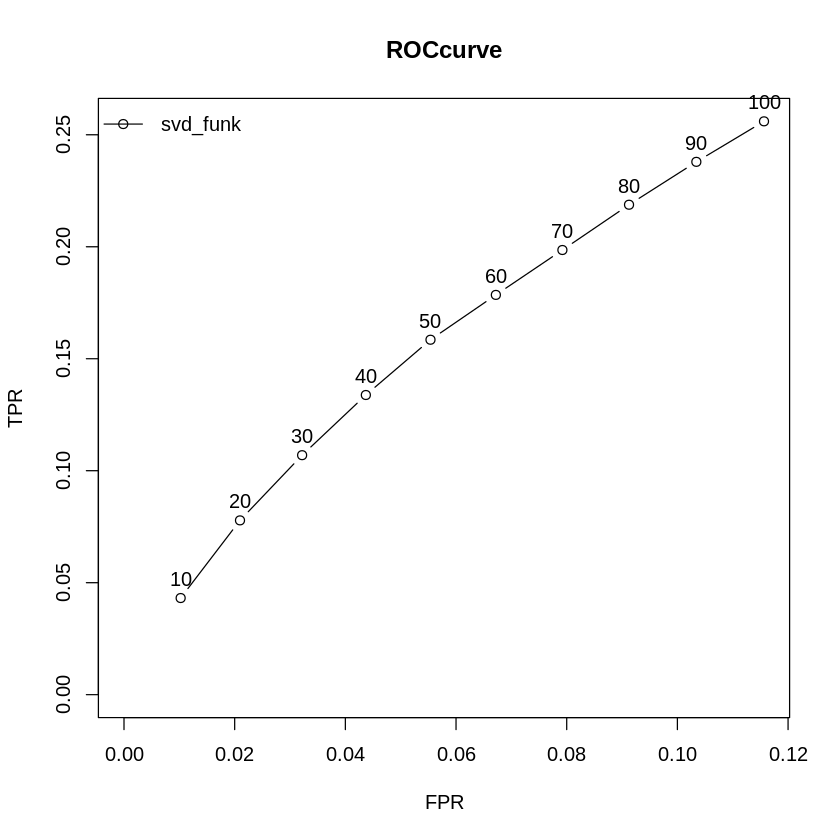

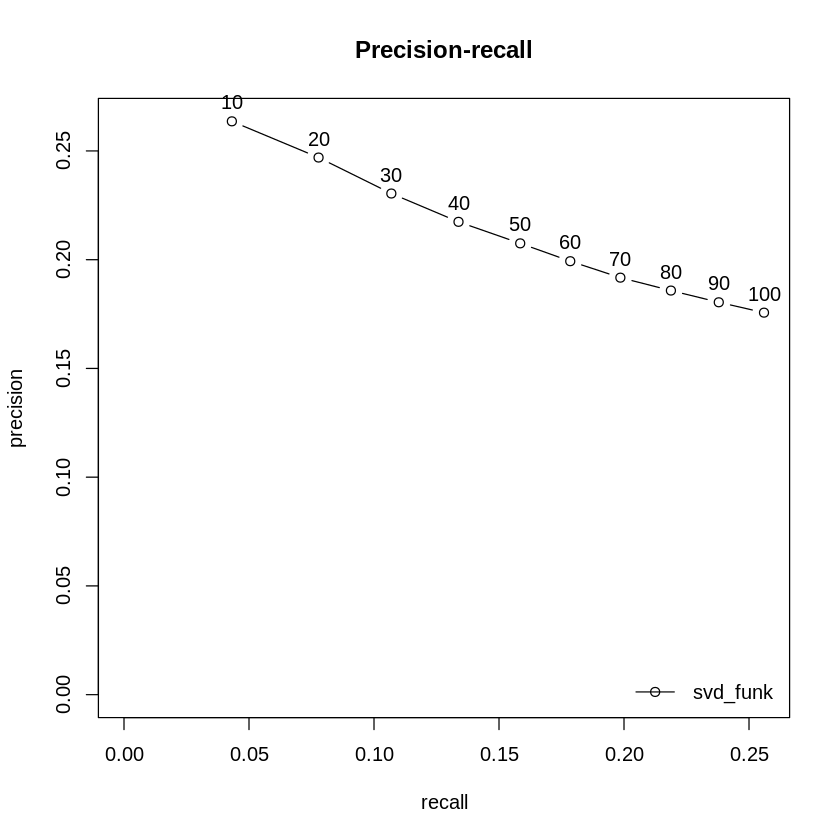

In [47]:
## INSERT YOUR CODE HERE
models_to_evaluate <- list(
svd_funk = list(name = "SVDF" ))
results_SVDF <- evaluate(x = eval_sets, method = models_to_evaluate, parameter=NULL, n =seq(10, 100, 10))

plot(results_SVDF, annotate = 1, legend = "topleft") 
title("ROCcurve")

plot(results_SVDF, "prec/rec", annotate = 1, legend = "bottomright")
title("Precision-recall")

## Exercise 3 (1 point) 

Change the default learning rate from 0.001 to 0.01 and repeat the evaluation using the same type="ratings"

In [48]:
#INSERT YOUR CODE HERE
models_to_evaluate <- list(
svd_funk = list(name = "SVDF", lambda=0.01 ))
results_SVDF <- evaluate(x = eval_sets, method = models_to_evaluate, n =seq(10, 100, 10), type='ratings')


SVDF run fold/sample [model time/prediction time]
	 1  [46.947sec/9.75sec] 
	 2  [38.744sec/8.375sec] 
	 3  [50.237sec/10.633sec] 
	 4  [46.64sec/9.672sec] 


## Exercise 4 (2 points)

Experiment with different values of k, from 5 to 20 in step of 5. Then plot a ROC graph to check what the best value of k is.



```
vector_k <- c(5, 10, 20, 30, 40)
models_to_evaluate <- lapply(vector_k, function(k){
list(name = "IBCF", param = list(method = "cosine", k = k))
})
names(models_to_evaluate) <- paste0("IBCF_k_", vector_k)
```



SVDF run fold/sample [model time/prediction time]
	 1  [25.055sec/5.253sec] 
	 2  [24.494sec/5.339sec] 
	 3  [24.709sec/5.492sec] 
	 4  [24.619sec/5.268sec] 
SVDF run fold/sample [model time/prediction time]
	 1  [46.202sec/9.855sec] 
	 2  [38.25sec/8.351sec] 
	 3  [49.8sec/10.661sec] 
	 4  [45.907sec/9.632sec] 
SVDF run fold/sample [model time/prediction time]
	 1  [52.892sec/11.238sec] 
	 2  [46.042sec/9.922sec] 
	 3  [61.363sec/13.132sec] 
	 4  [53.149sec/11.397sec] 
SVDF run fold/sample [model time/prediction time]
	 1  [61.771sec/13.188sec] 
	 2  [53.35sec/11.529sec] 
	 3  [61.432sec/12.909sec] 
	 4  [60.44sec/12.808sec] 
SVDF run fold/sample [model time/prediction time]
	 1  [71.864sec/15.298sec] 
	 2  [59.542sec/12.961sec] 
	 3  [67.397sec/14.433sec] 
	 4  [67.215sec/14.28sec] 


[1] "evaluationResultList"
attr(,"package")
[1] "recommenderlab"

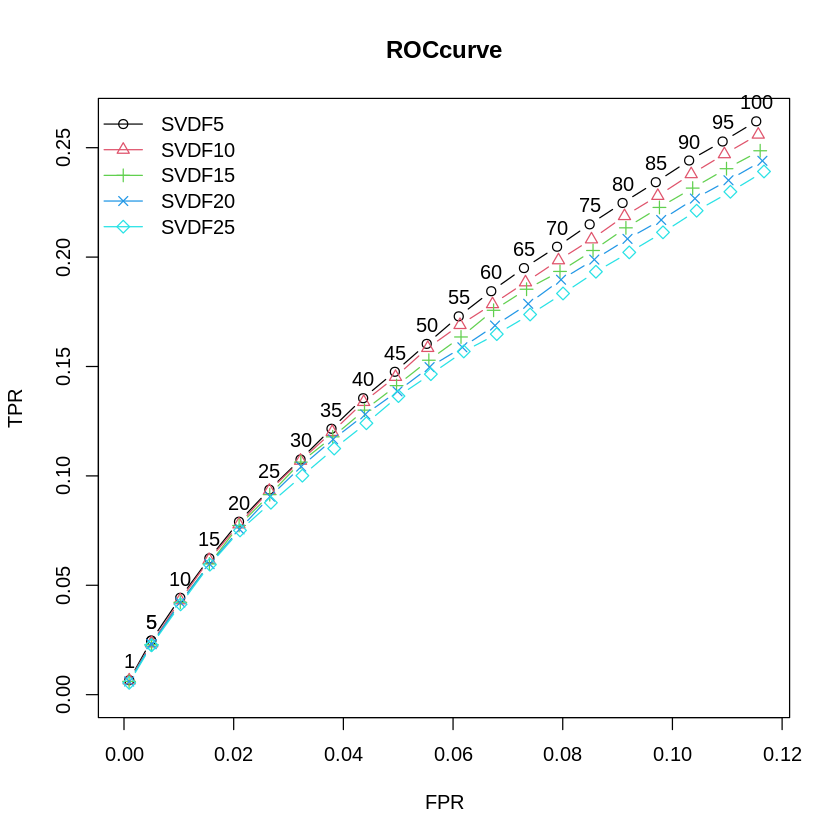

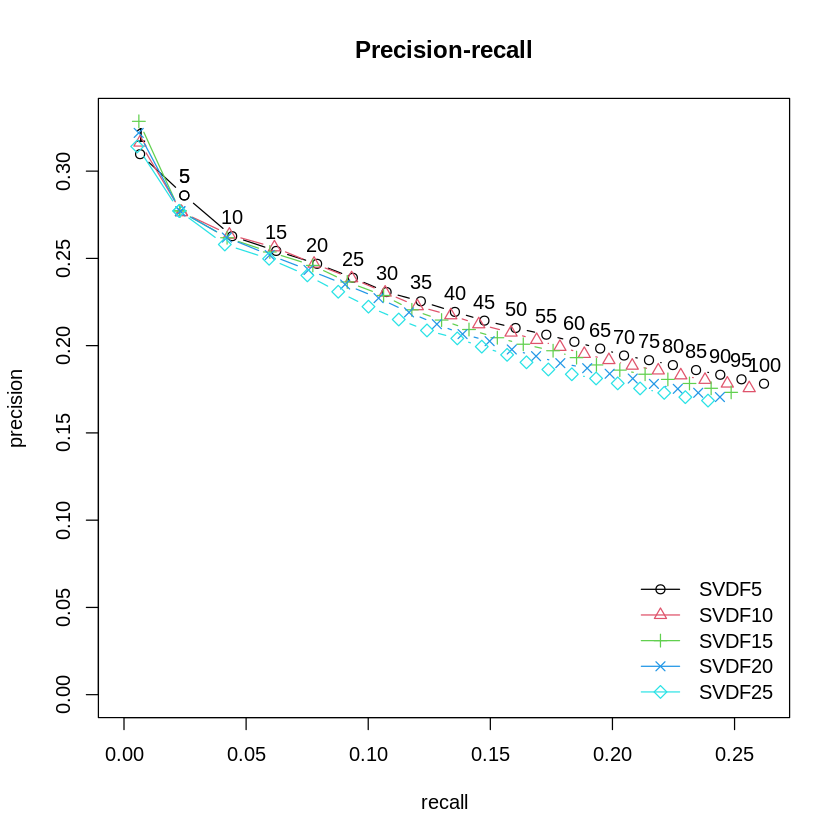

In [49]:
vector_k <- c(5, 10, 15, 20, 25)
models_to_evaluate <- lapply(vector_k, function(k){
list(name = "SVDF", param = list(k = k))
})
names(models_to_evaluate) <- paste0("SVDF", vector_k)

n_recommendations <- c(1, 5, seq(5, 100, 5))
list_results <- evaluate(x = eval_sets, method = models_to_evaluate, n= n_recommendations)
class(list_results)## evaluationResultList

plot(list_results, annotate = 1, legend = "topleft") 
title("ROCcurve")
plot(list_results, "prec/rec", annotate = 1, legend = "bottomright")
title("Precision-recall")

## Exercise 5 (2 points)

Compare the default version of SVD vs SVDF using the default parameters both for the alfgorithm and for the evaluation method.

SVDF run fold/sample [model time/prediction time]
	 1  [44.742sec/9.751sec] 
	 2  [37.476sec/8.348sec] 
	 3  [49.472sec/10.646sec] 
	 4  [45.878sec/9.867sec] 


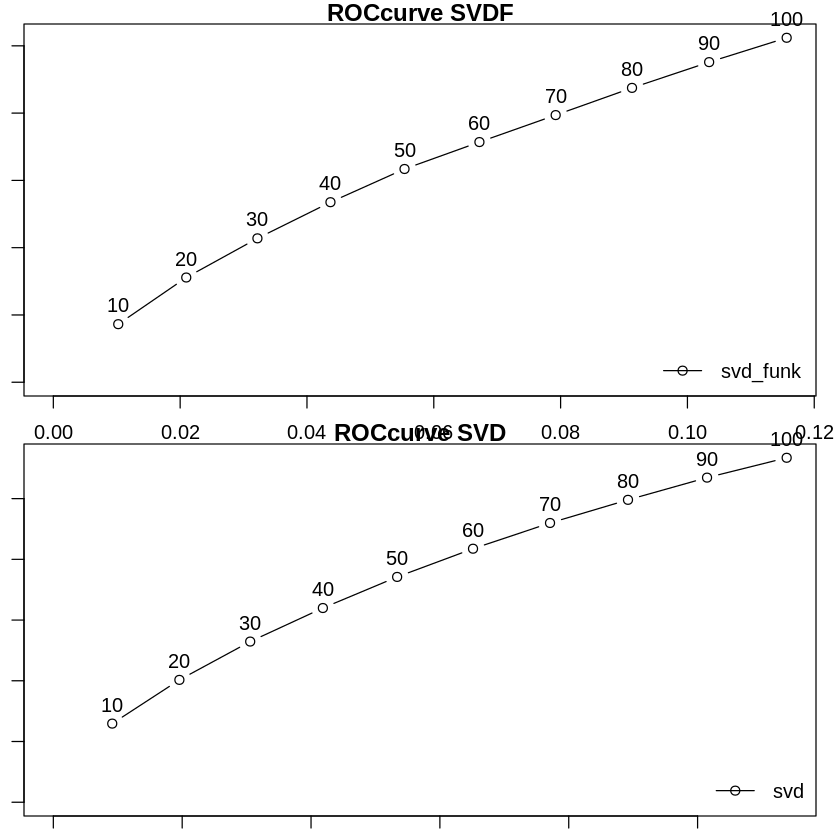

In [55]:
## INSERT CODE HERE
par(mar=c(1,1,1,1))
par(mfrow=c(2,1))

models_to_evaluate <- list(
svd_funk = list(name = "SVDF" ))
results_SVDF <- evaluate(x = eval_sets, method = models_to_evaluate, parameter=NULL, n =seq(10, 100, 10))
plot(results_SVDF, annotate = 1) 
title("ROCcurve SVDF")

plot(results_SVD, annotate = 1) 
title("ROCcurve SVD")

In [56]:
recommenderRegistry$get_entry("ALS", dataType="realRatingMatrix")

Recommender method: ALS for realRatingMatrix
Description: Recommender for explicit ratings based on latent factors, calculated by alternating least squares algorithm.
Reference: Yunhong Zhou, Dennis Wilkinson, Robert Schreiber, Rong Pan (2008). Large-Scale Parallel Collaborative Filtering for the Netflix Prize, 4th Int'l Conf. Algorithmic Aspects in Information and Management, LNCS 5034.
Parameters:
  normalize lambda n_factors n_iterations min_item_nr seed
1      NULL    0.1        10           10           1 NULL


# Bonus track

Compare previous SVD and SVD Funk with Alternating Least Square ALS



```
recommenderRegistry$get_entry("ALS", dataType="realRatingMatrix")

Recommender method: ALS for realRatingMatrix
Description: Recommender for explicit ratings based on latent factors, calculated by alternating least squares algorithm.
Reference: Yunhong Zhou, Dennis Wilkinson, Robert Schreiber, Rong Pan (2008). Large-Scale Parallel Collaborative Filtering for the Netflix Prize, 4th Int'l Conf. Algorithmic Aspects in Information and Management, LNCS 5034.
Parameters:
  normalize lambda n_factors n_iterations min_item_nr seed
1      NULL    0.1        10           10           1 NULL
```



ALS run fold/sample [model time/prediction time]
	 1  [0.001sec/29.592sec] 
	 2  [0sec/29.267sec] 
	 3  [0.001sec/29.417sec] 
	 4  [0sec/29.549sec] 


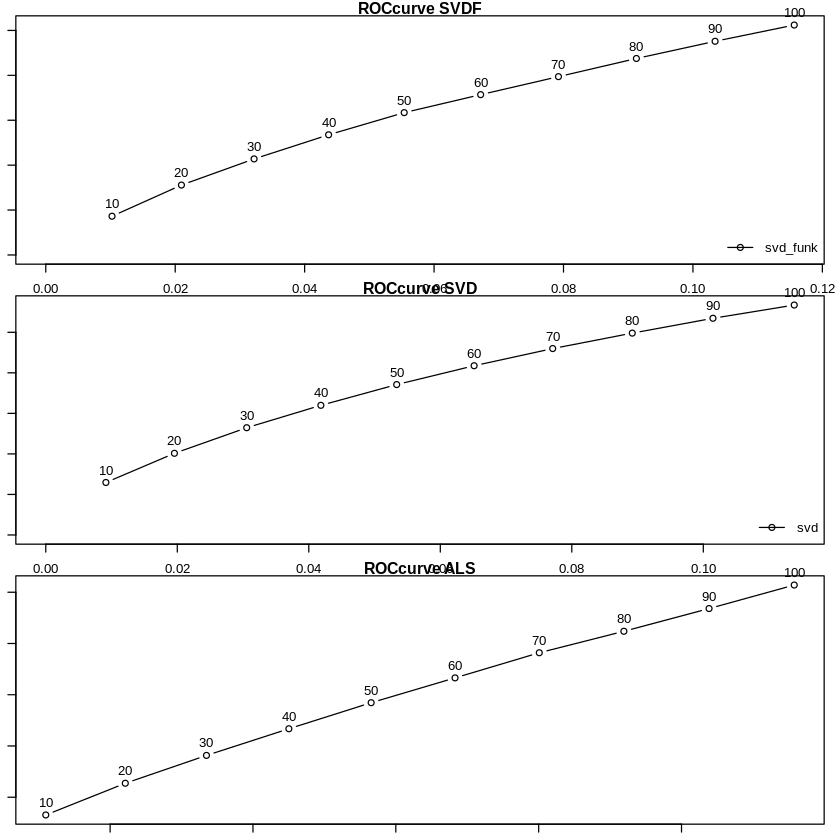

In [57]:
results_ALS <- evaluate(x = eval_sets, method = "ALS",parameter=NULL, n =seq(10, 100, 10))
par(mar=c(1,1,1,1))
par(mfrow=c(3,1))

plot(results_SVDF, annotate = 1) 
title("ROCcurve SVDF")

plot(results_SVD, annotate = 1) 
title("ROCcurve SVD")

plot(results_ALS, annotate = 1) 
title("ROCcurve ALS")